<a href="https://colab.research.google.com/github/bhavyasri466/deep-learning-with-pytorch-image-segmentation/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (3/3), done.


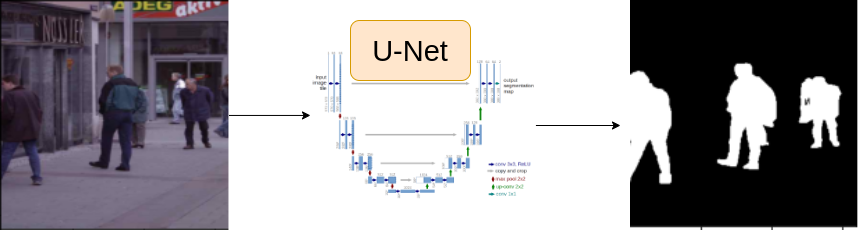

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'
DEVICE='cuda'

EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[0]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

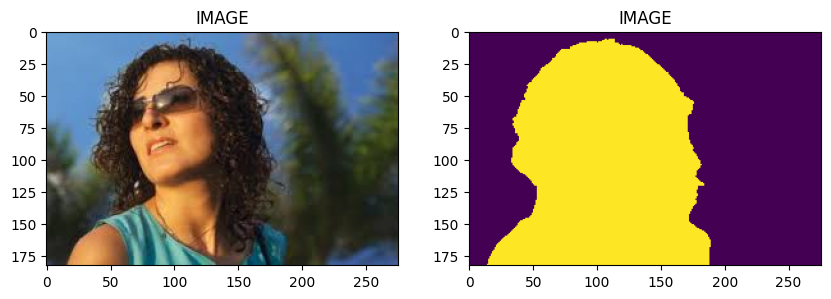

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('IMAGE')
ax2.imshow(mask)

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
 class SegmentationDataset(Dataset):
   def __init__(self,df,augmentations):
     self.df=df
     self.augmentations=augmentations
   def __len__(self):
     return len(self.df)
   def __getitem__(self,idx):
     row=self.df.iloc[idx]
     image_path=row.images
     mask_path=row.masks
     image=cv2.imread(image_path)
     image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
     mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
     mask=np.expand_dims(mask,axis=-1)

     if self.augmentations:
       data=self.augmentations(image=image,mask=mask)
       image=data["image"]
       mask=data["mask"]
     image=np.transpose(image,(2,0,1)).astype(np.float32)
     mask=np.transpose(mask,(2,0,1)).astype(np.float32)
     image=torch.tensor(image)
     mask=torch.tensor(mask)
     return image,mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [ ]:
idx=32
image,mask=trainset[idx]
helper.show_image(image,mask)

AttributeError: module 'helper' has no attribute 'show_image'

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image,mask in trainloader:
  break
  print(f"Image batch shape : {image.shape}")
  print(f"Mask batch shape : {mask.shape}")

ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

# Task 7 : Create Train and Validation Function

# Task 8 : Train Model

# Task 9 : Inference

In [ ]:
image_path = "/content/Human-Segmentation-Dataset-master/Ground_Truth/1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
def show_image(image, mask):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.permute(1, 2, 0).squeeze().numpy()

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.set_title('IMAGE')
    ax1.imshow(image)

    ax2.set_title('MASK')
    ax2.imshow(mask)
    plt.show()